In [20]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [21]:
# download a test image
from os import path
if not path.exists("inputs/avergra2.bmp"):  # avergra = avarage gradient
    !wget https://users.itk.ppke.hu/~horan/avergra2.bmp -P ./inputs/

In [22]:
def Uint8ToCell(arr):
    # This function convertrs an array from unit8, 0-255, oBlack, 255White
    # to -1White, 1Black
    arr = (-1)*((arr.astype(float))/127.5-1.0)
    return arr

In [23]:
def CellToUint8(arr):
    # This function converts an array from unit8, 0-255, oBlack, 255White
    # to -1White, 1Black
    arr = ((arr*-1)+1.0)*127.5
    arr = arr.astype(np.uint8)
    return arr

# Élkereső template használata torch-ban

torch.Size([64, 64])
torch.Size([3, 3])
torch.Size([1, 1, 64, 64])


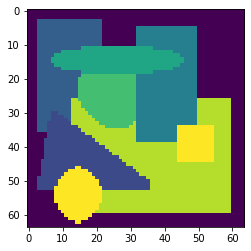

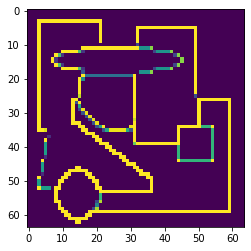

In [24]:
h = 0.1
iter_num = 20

# Kép importálása és konvertálása
img = cv2.imread("inputs/avergra2.bmp")
img = Uint8ToCell(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))

B = torch.tensor([[-1.0, -1.0, -1.0], [-1.0, 8.0, -1.0], [-1.0, -1.0, -1.0]])
A = torch.tensor([[0.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 0.0]])
Z = torch.tensor(-1.0)

U = torch.tensor(img).float()
print(U.shape)
print(B.shape)

# conv2d() fv 4D adatokat vár: batch_size x channels x img_width x img_height
# Jelen esetben: 1x1x64x64 mivel 1 képünk van, ami szürke, és 64x64 pixel
# Ehhez az U változónkat át kell alakítanunk
U = U.view(1, 1, img.shape[0], img.shape[1])
# És a tensorokat is amikkel konvolválni akarunk
B = B.view(1, 1, 3, 3)
A = A.view(1, 1, 3, 3)

# Állapotváltozó szintén a kép
x = U.view(1, 1, img.shape[0], img.shape[1])

forward_coupling = torch.nn.functional.conv2d(U, B, padding=1) + Z
# Ha nem lenne padding, akkor az eredmény mérete kisebb lenne,
# mivel a kép szélein nem tud konvolválni
print(forward_coupling.shape)

# Xdot = -x + AY + BU + z
for it in range(iter_num):
    y = torch.clamp(x, -1.0, 1.0)
    backward_coupling = torch.nn.functional.conv2d(y, A, padding=1)
    x = x + h*(-1.0 * x + backward_coupling + forward_coupling)

out = torch.clamp(x, -1.0, 1.0)

plt.imshow(img)

plt.figure()
plt.imshow(out[0, 0, :, :].numpy())

# Élkereső template létrehozása visszapropagálással

Az előző élkereső template megoldását kimentjük, így ismert a kimenet és a bemenet, és a template-eket akarjuk meghatározni.

In [25]:
np.save("./outputs/ExpectedOutput.npy", out)

Templatek meghatározása:

Parameter containing:
tensor([[[[ 0.0492, -0.0524,  0.0041],
          [-0.0956,  1.7838,  0.0042],
          [-0.0547,  0.1200, -0.0714]]]], requires_grad=True)
Parameter containing:
tensor([[[[-6.9196e-01, -2.0693e-01, -4.7567e-01],
          [-6.7613e-04,  2.1782e+00, -3.7468e-01],
          [-3.3411e-01, -6.4531e-01, -2.1569e-01]]]], requires_grad=True)
Parameter containing:
tensor([-0.4094], requires_grad=True)


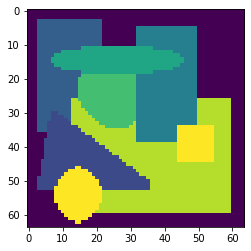

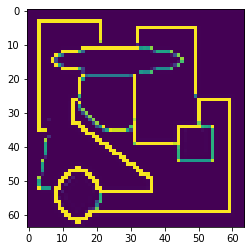

In [26]:
h = 0.1
iter_num = 20

# Kép importálása és konvertálása
img = cv2.imread("inputs/avergra2.bmp")
img = Uint8ToCell(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))

B = torch.nn.Parameter(torch.rand([1, 1, 3, 3]))
A = torch.nn.Parameter(torch.rand([1, 1, 3, 3]))
Z = torch.nn.Parameter(torch.rand([1]))

opt = torch.optim.Adam([A, B, Z], lr=0.01)

U = torch.tensor(img).float().view(1, 1, img.shape[0], img.shape[1])
expected_output = torch.tensor(np.load("./outputs/ExpectedOutput.npy"))

alpha = 0.01
for i in range(1000):
    opt.zero_grad()
    forward_coupling = torch.nn.functional.conv2d(U, B, padding=1) + Z
    x = U

    for it in range(iter_num):
        # y = torch.clamp(x, -1.0, 1.0)
        # Ezt nem használhatjuk, mert -1 alatt és 1 fölött a gradiens mindig 0,
        # ezért ezeken a tartományokon hiába változtatunk a paraméter értékén,
        # nem lesz tovább optimalizálható.
        # Dead relu probléma, megoldása a leaky nonlinearitás,
        # vagyis hogy a -1 és 1-en kívüli szakaszoknak van egy kis lejtése az
        # origó irányába.
        # Leaky nonlin a pozitív irányban: min(x; 1 + alpha*x),
        # ahol alpha a meredekség.
        # Leaky nonlin a negatív irányban: max(x, -1 - alpha*x)
        y = torch.minimum(x, 1 + alpha*x)
        y = torch.maximum(y, -1 - alpha*y)
        backward_coupling = torch.nn.functional.conv2d(y, A, padding=1)
        x = x + h*(-1.0 * x + backward_coupling + forward_coupling)
    # itt is fennáll a dead relu probléma, úgyhogy leaky nonlin kell
    out = torch.minimum(x, 1 + alpha*x)
    out = torch.maximum(out, -1 - alpha*x)
    loss = torch.mean(torch.square(expected_output - out))  # négyzetes hiba
    loss.backward()
    opt.step()

plt.imshow(img)
plt.figure()
plt.imshow(out[0, 0, :, :].detach().numpy())  # detach: elvesszük a gradiensét

print(A)
print(B)
print(Z)